<a href="https://colab.research.google.com/github/koshygeoji/Food-classification-and-clorie-estimation-GUI/blob/master/Food101_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food-101 Dataset


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Oct  5 16:39:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download and extract Food 101 Dataset

In [ ]:
import re
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)


Tensorflow version 2.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#存放food-101数据集的路径
cd '/content/gdrive/My Drive/Food Image Recognition'

/content/gdrive/My Drive/Food Image Recognition


In [ ]:
# 解压food101数据集（若已有数据集，跳过这一步）
!wget -P data http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz 
!tar -xzf data/food-101.tar.gz -C data

--2020-10-03 07:50:52--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2020-10-03 07:50:53--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘data/food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  23.9MB/s    in 3m 26s  

2020-10-03 07:54:19 (23.2 MB/s) - ‘data/food-101.tar.gz’ saved [4996278331/4996278331]



In [ ]:
ls

data/  food-101.tar.gz  food_app-master/  food_recipe_cnn_master/  history.log


In [ ]:
from __future__ import division


import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np
import os


def create_model():
  
  inception = InceptionV3(input_shape=(299,299,3),include_top=False,weights='imagenet')
  inception.trainable=False
  base = inception.output
  
  x = GlobalAveragePooling2D(name='GlobalPooling')(base)
  #x = Dense(128,activation='relu')(x)
  x = Dense(128,activation='relu',name='Dense1')(x)
  x = Dropout(0.2,name='Dropout1')(x)
  x = Dense(128,activation='relu',name='Dense2')(x)
  x = Dropout(0.2,name='Dropout2')(x)

  # predictions = Dense(101, activation='softmax',name='output')(x)
  # 基于食品类别总数进行修改
  predictions = Dense(5, activation='softmax',name='output')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model
  



In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

**images** folder contains 101 folders with 1000 images

### Visualize random image from each of the 101 classes

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import os

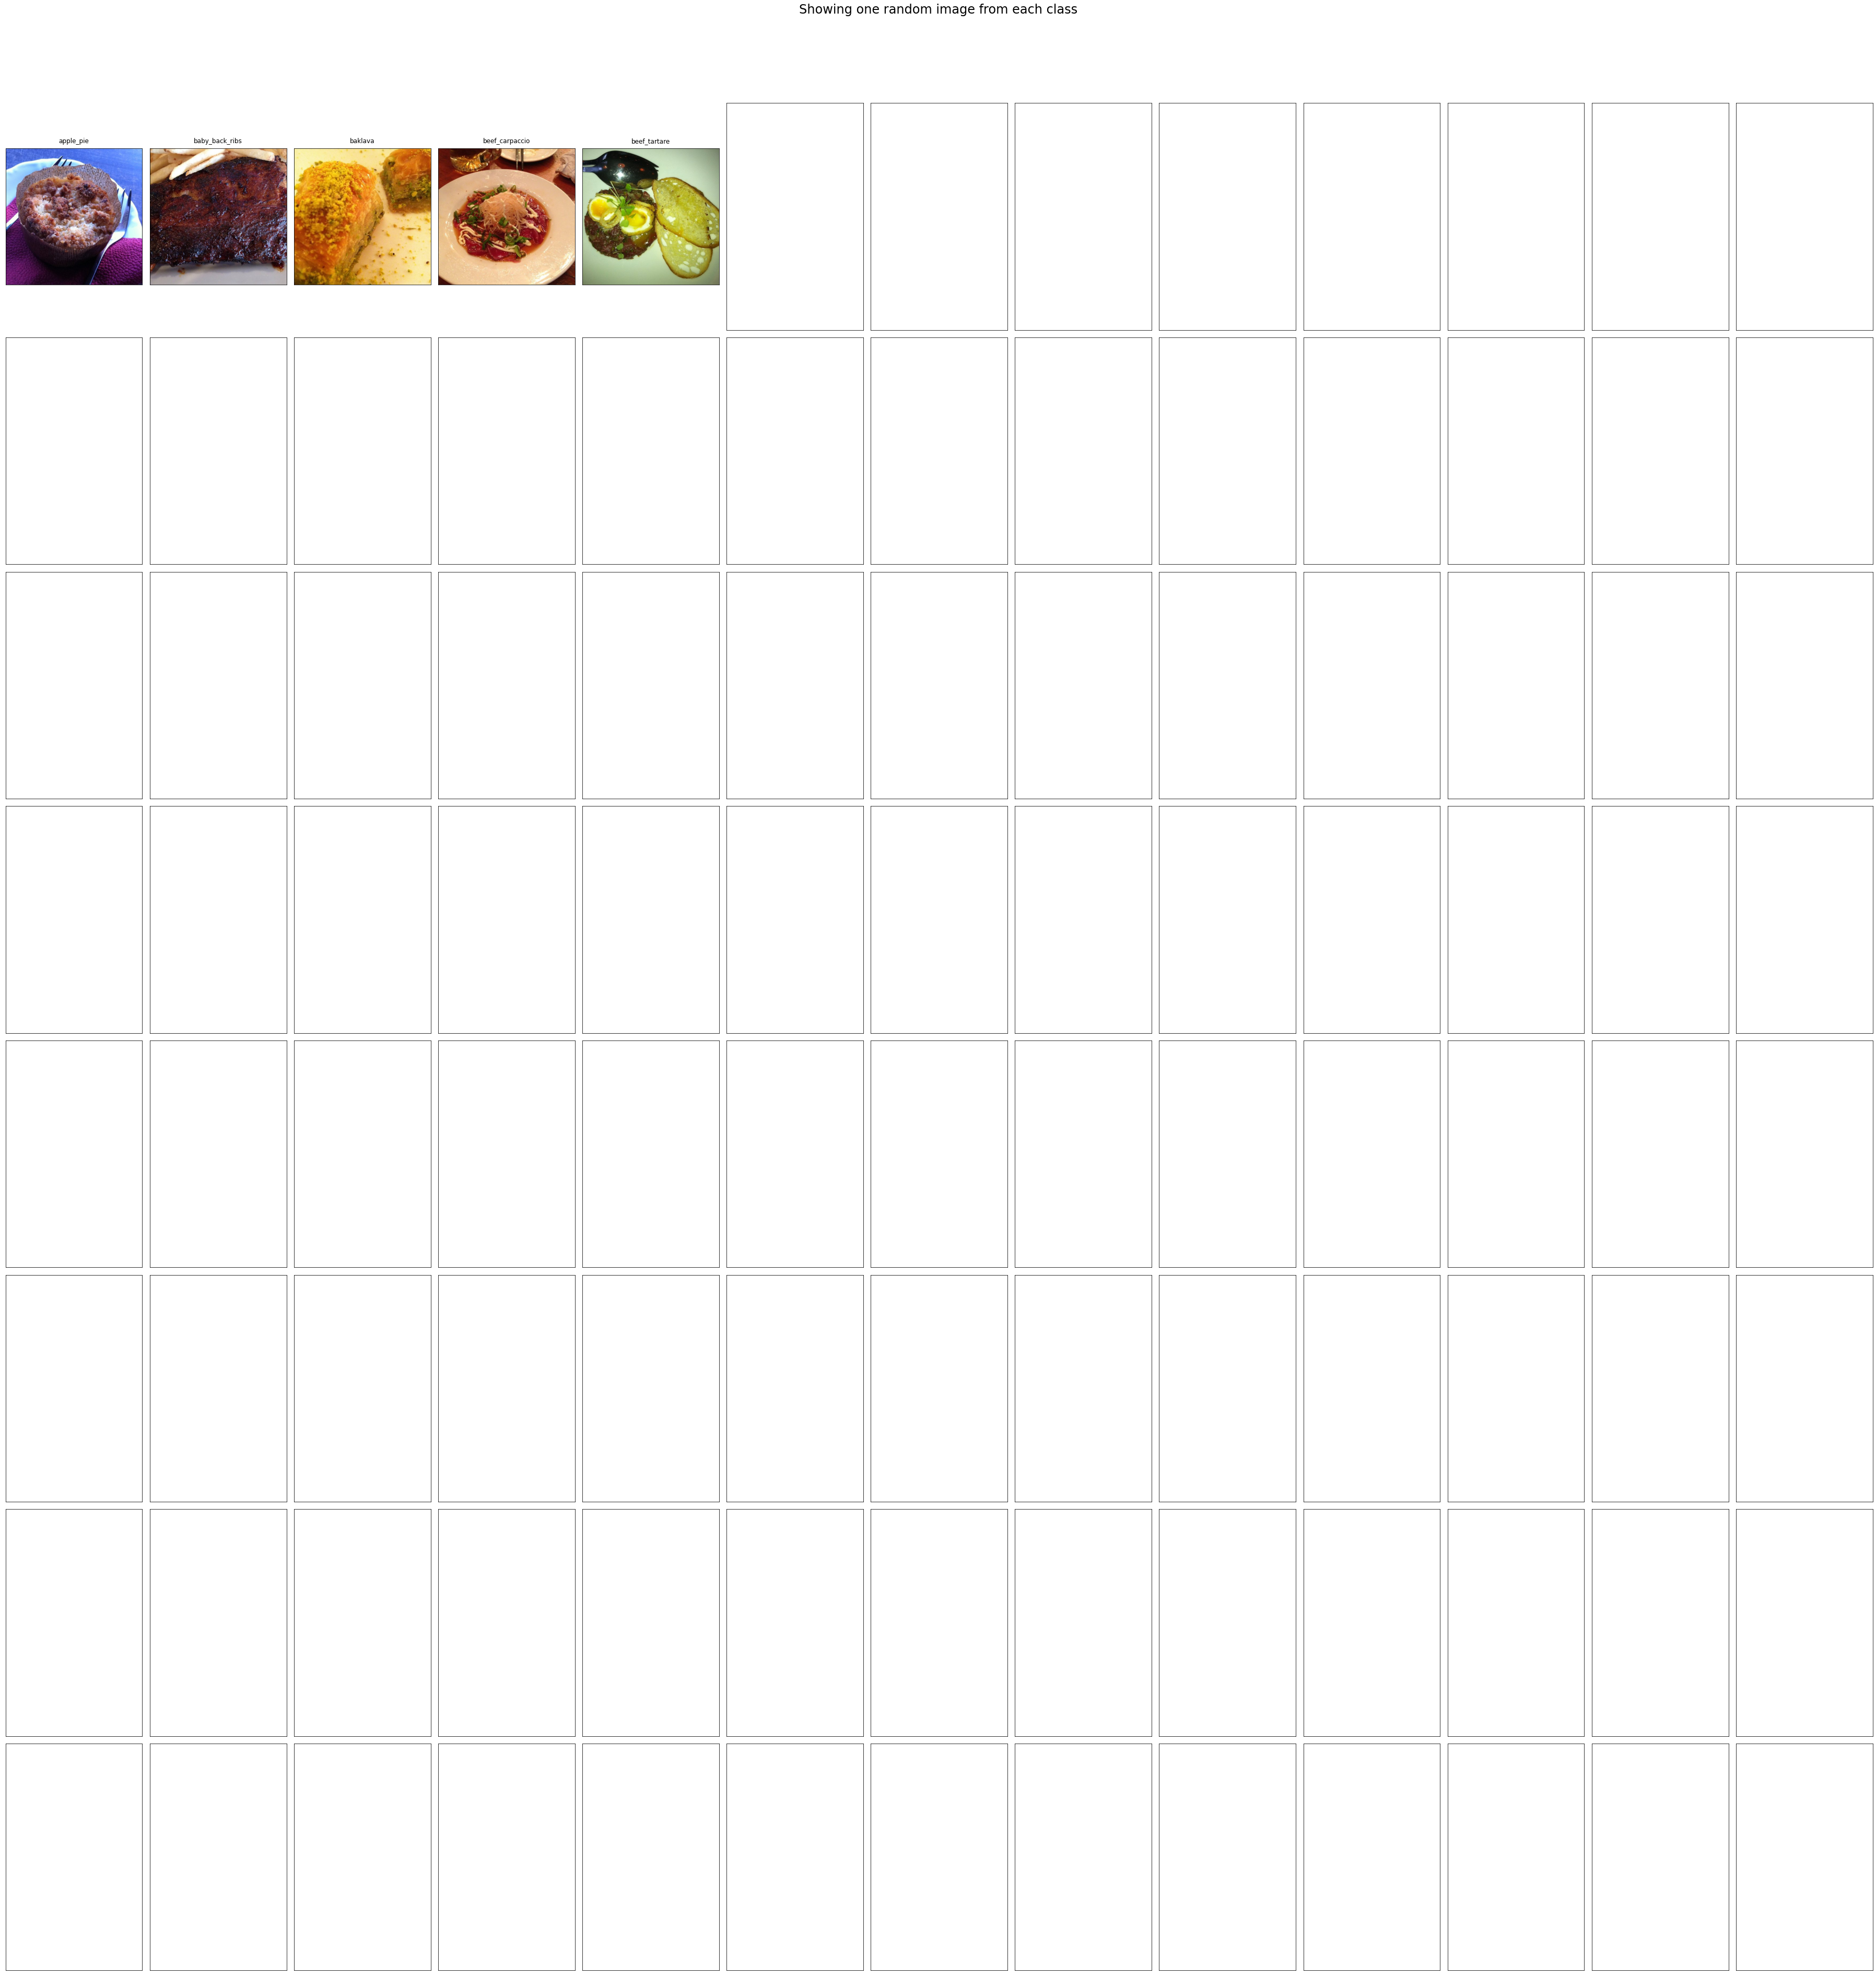

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 8
cols = 13
fig, ax = plt.subplots(rows, cols, figsize=(50,50))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
# data_dir = "data/food-101/images/"
# images是完整数据集，selected是我抽出来部分的
data_dir = "data/food-101/selected/"

foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()



### Split the image data into train and test using train.txt and test.txt




### Inception model using Food 101 dataset

In [ ]:
# 若用colab，需要先将隐藏文件夹.ipynb_checkpoints/删掉，不能会被列入计数
ls -al data/food-101/images

total 404
drwx------ 2 root root 4096 Sep 21  2013 apple_pie/
drwx------ 2 root root 4096 Sep 21  2013 baby_back_ribs/
drwx------ 2 root root 4096 Sep 21  2013 baklava/
drwx------ 2 root root 4096 Sep 21  2013 beef_carpaccio/
drwx------ 2 root root 4096 Sep 21  2013 beef_tartare/
drwx------ 2 root root 4096 Sep 21  2013 beet_salad/
drwx------ 2 root root 4096 Sep 21  2013 beignets/
drwx------ 2 root root 4096 Sep 21  2013 bibimbap/
drwx------ 2 root root 4096 Sep 21  2013 bread_pudding/
drwx------ 2 root root 4096 Sep 21  2013 breakfast_burrito/
drwx------ 2 root root 4096 Sep 21  2013 bruschetta/
drwx------ 2 root root 4096 Sep 21  2013 caesar_salad/
drwx------ 2 root root 4096 Sep 21  2013 cannoli/
drwx------ 2 root root 4096 Sep 21  2013 caprese_salad/
drwx------ 2 root root 4096 Sep 21  2013 carrot_cake/
drwx------ 2 root root 4096 Jul  9  2014 ceviche/
drwx------ 2 root root 4096 Sep 21  2013 cheesecake/
drwx------ 2 root root 4096 Sep 21  2013 cheese_plate/
drwx------ 2 root root

In [ ]:
# 若用colab，需要先将隐藏文件夹.ipynb_checkpoints/删掉，不能会被列入计数
import os, sys
import shutil
shutil.rmtree("data/food-101/images/.ipynb_checkpoints")

In [ ]:
# Let's use a Inceptionv3 model on subset of data with 101 food classes

K.clear_session()
# batch_size=128
batch_size=64

# n_classes = 101
n_classes = 5

img_width, img_height = 299, 299
# train_data_dir = 'data/food-101/images'

train_data_dir = 'data/food-101/selected'


train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
    )


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')




Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [ ]:
#retrain if required

checkpointer = ModelCheckpoint(filepath='best_model_class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')

history_class = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    epochs=10,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_101_class.hdf5')

Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 0.9217 - accuracy: 0.6255 
Epoch 00001: val_loss improved from inf to 0.60259, saving model to best_model_class.hdf5
62/62 [==============================] - 2182s 35s/step - loss: 0.9217 - accuracy: 0.6255 - val_loss: 0.6026 - val_accuracy: 0.7760
Epoch 2/10
62/62 [==============================] - ETA: 0s - loss: 0.5861 - accuracy: 0.7764
Epoch 00002: val_loss improved from 0.60259 to 0.57648, saving model to best_model_class.hdf5
62/62 [==============================] - 116s 2s/step - loss: 0.5861 - accuracy: 0.7764 - val_loss: 0.5765 - val_accuracy: 0.7948
Epoch 3/10
62/62 [==============================] - ETA: 0s - loss: 0.5014 - accuracy: 0.8089
Epoch 00003: val_loss improved from 0.57648 to 0.48480, saving model to best_model_class.hdf5
62/62 [==============================] - 117s 2s/step - loss: 0.5014 - accuracy: 0.8089 - val_loss: 0.4848 - val_accuracy: 0.8250
Epoch 4/10
62/62 [=============================

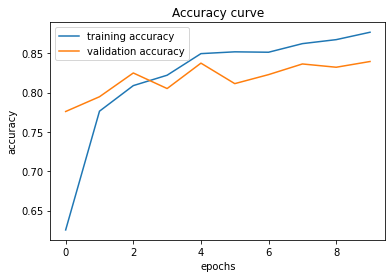

In [ ]:
history=history_class
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Accuracy curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

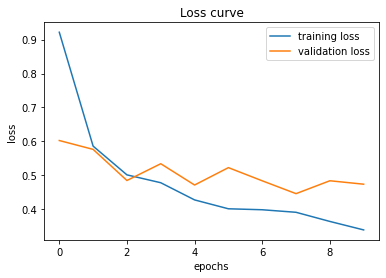

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
# Loading the best saved model to make predictions
from tensorflow.keras.models import load_model
model_best = load_model('/content/gdrive/My Drive/Food Image Recognition/model_trained_101_class.hdf5',compile=False)

In [ ]:
# food_list=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles']
food_list=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare'] #目前以五类来进行测试
food_list.sort()

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0) #tensor-n dimen  4      
    img /= 255.                                      
    #global pred
    pred = model_best.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

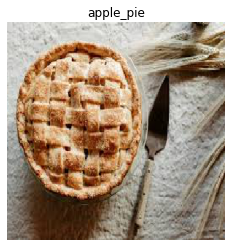

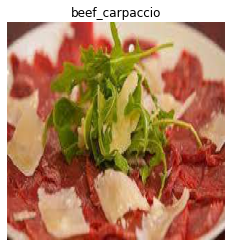

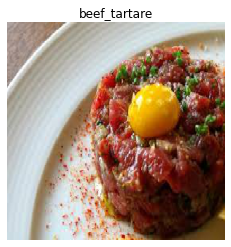

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('/content/gdrive/My Drive/Food Image Recognition/data/food-101/test1.jpg')
images.append('/content/gdrive/My Drive/Food Image Recognition/data/food-101/test2.jpg')
images.append('/content/gdrive/My Drive/Food Image Recognition/data/food-101/test3.jpg')
predict_class(model_best, images, True)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('confusion_matrix')
print(confusion_matrix(gnd_truth, pred_value,labels=food_list))

In [ ]:
print('classification_report')
print(classification_report(gnd_truth, pred_value,labels=food_list))